<h3 style="text-align: center;"><b>Классификация</b></h3>
<h3 style="text-align: center;"><b>с применением методов классического машинного обучения</b></h3>

In [280]:
def foo(data, config):
    # winsorise
    if config['winsorise']:
        lower_pct, upper_pct = 0.005, 0.995

        for num in ['MonthlySpending']:
            lower_cap = data[num].quantile(lower_pct)
            upper_cap = data[num].quantile(upper_pct)

            data[num] = data[num].clip(lower=lower_cap,
                                       upper=upper_cap)
    
    # interaction terms
    if config['cross']:
        def interactionTerms(data, features):
            res = (data[features[0]] == 'Yes')
            for feature in features[1:]:
                res &= (data[feature] == 'Yes')

            name = features[0]
            for feature in features[1:]:
                name += f'+{feature}'

            data[name] = (res).astype(int)
            cat_cols.append(name)
        
        interactionTerms(data, 'HasChild+HasMovieSubscription+HasMultiplePhoneNumbers+IsBillingPaperless+IsSeniorCitizen'.split('+'))


# Первая часть. Исследование

In [281]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import catboost  # документация: https://catboost.ai/docs
from catboost import CatBoostClassifier

import optuna
from optuna.integration import OptunaSearchCV
from optuna.integration import CatBoostPruningCallback
from optuna.distributions import (
    IntDistribution,
    FloatDistribution,
    CategoricalDistribution
)

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import randint, uniform, zscore

import logging
from copy import deepcopy
import random
 
# from tqdm.notebook import tqdm

In [282]:
logging.basicConfig(
    # level=logging.DEBUG,
    level=logging.INFO,
    # level=logging.WARNING,
    format="{asctime} - {levelname} - {message}",
    style="{",
    datefmt="%Y-%m-%d %H:%M",
)

## Загрузка данных 

In [283]:
raw_data = pd.read_csv('./content/train.csv')
data = deepcopy(raw_data)

In [284]:
# numerics
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# categoricals
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

cleanup

In [285]:
# deal with rows with empty strings in TotalSpent
data['TotalSpent'] = data['TotalSpent'].replace(' ', '0')

# convert string numbers to floats
# since we are working with tree-based models, we can leave the ints
data = data.astype({'TotalSpent': 'float64'})

# convert IsSeniorCitizen from {0, 1} to {No, Yes}
data['IsSeniorCitizen'] = data['IsSeniorCitizen'].map({0: 'No', 1: 'Yes'})

## Анализ данных 

### numerics

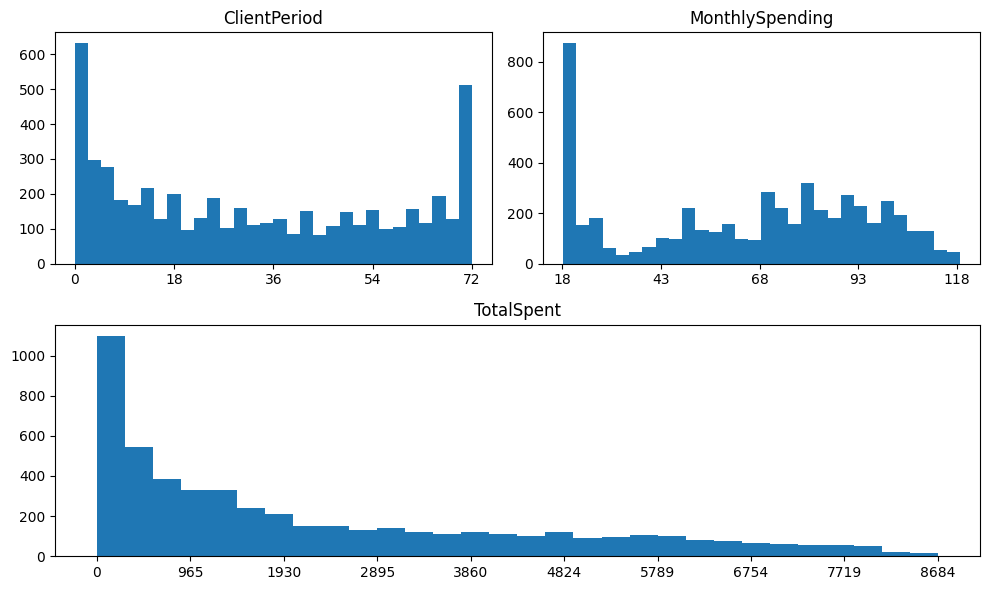

In [286]:
"""
Look at numerical features' distributions 
"""

def hists(win=False):
    fig = plt.figure(figsize=(10, 6))

    ax0 = plt.subplot2grid((2,2), (0,0))
    ax1 = plt.subplot2grid((2,2), (0,1))

    ax2 = plt.subplot2grid((2,2), (1,0), colspan=2)

    axes = [ax0, ax1, ax2]

    for ax, feature in zip(axes, num_cols):
        if win:
            feature += '_win'
        ax.hist(data[feature], bins=30)
        ax.set_title(feature)

        n = 10 if ax == ax2 else 5
        ax.set_xticks(np.linspace(int(data[feature].min()), 
                                int(data[feature].max()), n))

    plt.tight_layout()
    plt.show()
hists()

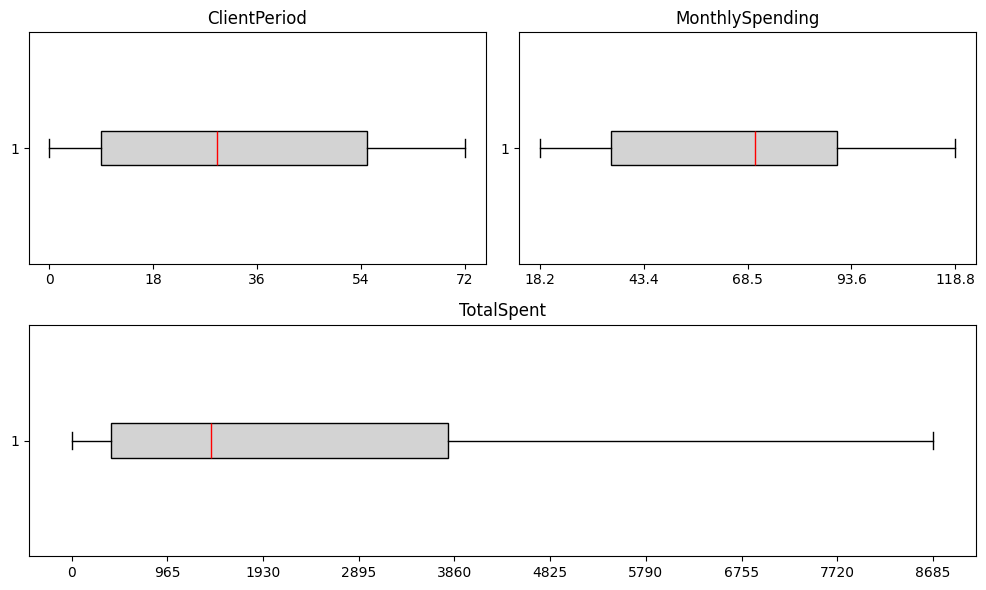

In [287]:
def boxplots(win=False):
    fig = plt.figure(figsize=(10, 6))

    ax0 = plt.subplot2grid((2,2), (0,0))
    ax1 = plt.subplot2grid((2,2), (0,1))
    ax2 = plt.subplot2grid((2,2), (1,0), colspan=2)

    axes = [ax0, ax1, ax2]

    for ax, feature in zip(axes, num_cols):
        if win:
            feature += '_win'
        # draw a horizontal boxplot
        ax.boxplot(data[feature], vert=False, patch_artist=True,
                boxprops=dict(facecolor='lightgray', edgecolor='black'),
                medianprops=dict(color='red'))
        ax.set_title(feature)
        
        # optionally set x-ticks for consistency
        n = 10 if ax == ax2 else 5
        ax.set_xticks(np.linspace(data[feature].min(), data[feature].max(), n))

    plt.tight_layout()
    plt.show()
boxplots()

### Winsorise (+= ~0.00047 on test)

In [288]:
# lower_pct, upper_pct = 0.005, 0.995

# for num in ['MonthlySpending']:
#     lower_cap = data[num].quantile(lower_pct)
#     upper_cap = data[num].quantile(upper_pct)

#     data[f'{num}'] = data[num].clip(lower=lower_cap,
#                                     upper=upper_cap)

#     print(f'{num} winsorized')
#     print(f"Lower cap ({lower_pct*100:.1f}th pct):", lower_cap)
#     print(f"Upper cap ({upper_pct*100:.1f}th pct):", upper_cap)

### log1p (no win)

In [289]:
# data['TotalSpent'] = np.log1p(data['TotalSpent'])

# data['zscore'] = zscore(data['TotalSpent'])
# data = data[data['zscore'].abs() <= 3].drop(columns='zscore')

### categoricals

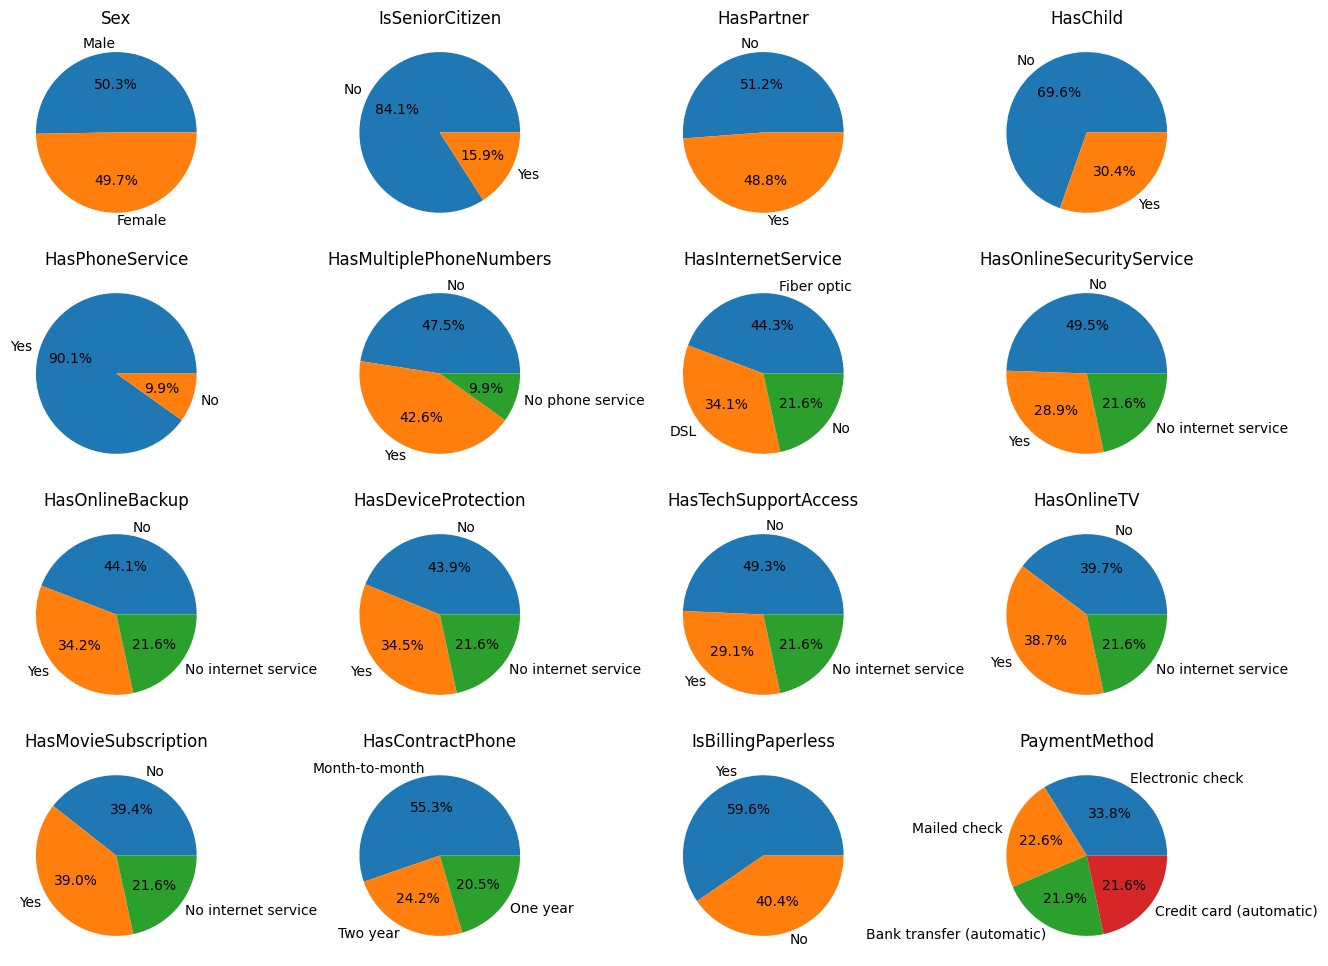

In [290]:
"""
Look at categorical features' distributions 
"""

def pies():
    n = len(cat_cols)

    n_cols = 4
    n_rows = n // n_cols

    n_rows += 1 if n % n_cols != 0 else 0

    fig, axes = plt.subplots(
        nrows = n_rows,
        ncols = n_cols,
        figsize = (n_cols * 4, n_rows * 3)
    )
    axes = axes.flatten()

    for ax, cat in zip(axes, cat_cols):
        counts = data.value_counts(cat)
        ax.pie(
            counts, 
            labels = counts.index,
            autopct='%1.1f%%'
        )
        ax.set_title(cat)

    for ax in axes[n:]:
        fig.delaxes(ax)

    plt.show()
pies()

### Interaction Terms (+= ~0.001 on test)

In [291]:
# def interactionTerms(data, features):
#     res = (data[features[0]] == 'Yes')
#     for feature in features[1:]:
#         res &= (data[feature] == 'Yes')

#     name = features[0]
#     for feature in features[1:]:
#         name += f'+{feature}'

#     data[name] = (res).astype(int)
#     cat_cols.append(name)

# # interactionTerms(data, 'HasTechSupportAccess+HasPartner+HasPhoneService'.split('+'))
# # interactionTerms(data, 'IsBillingPaperless+HasMultiplePhoneNumbers+HasOnlineTV'.split('+'))
# # interactionTerms(data, 'HasOnlineTV+HasMultiplePhoneNumbers+HasPhoneService+IsBillingPaperless'.split('+'))
# # interactionTerms(data, 'HasOnlineTV+HasPhoneService+HasOnlineBackup+HasDeviceProtection'.split('+'))
# interactionTerms(data, 'HasChild+HasMovieSubscription+HasMultiplePhoneNumbers+IsBillingPaperless+IsSeniorCitizen'.split('+'))
# # interactionTerms(data, 'HasChild+HasMovieSubscription+IsBillingPaperless+HasTechSupportAccess+HasDeviceProtection'.split('+'))
# # interactionTerms(data, 'HasOnlineTV+HasPhoneService+HasOnlineBackup+IsBillingPaperless+IsSeniorCitizen'.split('+'))

### target

<Axes: ylabel='Churn'>

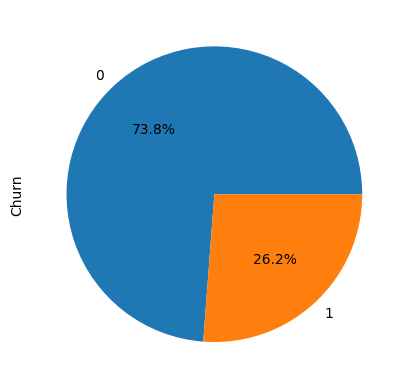

In [292]:
"""
Look at target
"""

data.value_counts(target_col).plot.pie(label=target_col, autopct='%1.1f%%')  # unbalanced

## LogisticRegression hyper-parameter tuning with sklearn

In [ ]:
# define parameter grids for models and preprocessing steps
# syntax: 'step_name__parameter_name' 

cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

PARAM_GRID = [
    {'model__solver':['lbfgs'],
     'model__penalty':['l2'],
     'model__C':[.005,.01,.1,1,10,100],
     'model__class_weight':['balanced',None]},

    {'model__solver':['liblinear'],
     'model__penalty':['l1','l2'],
     'model__C':[.005,.01,.1,1,10,100],
     'model__class_weight':['balanced',None]},

    {'model__solver':['saga'],
     'model__penalty':['l1', 'l2'],
     'model__C':[.005,.01,.1,1,10,100],
     'model__class_weight':['balanced',None]},

    {'model__solver':['saga'],
     'model__penalty':['elasticnet'],
     'model__l1_ratio':[.1,.5,.9],
     'model__C':[.005,.01,.1,1,10,100],
     'model__class_weight':['balanced',None]}
]

# redefine the pipeline *specifically for tuning*
pipeline = Pipeline([
    ('preprocessing', ColumnTransformer(
        transformers=[
            ('categorical', Pipeline([
                ('onehot_encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
            ]), make_column_selector(dtype_include=object)),
            ('numerical', Pipeline([
                ('scaler', RobustScaler()),
            ]), make_column_selector(dtype_include=np.number))
        ],
        remainder='passthrough'
    )),
    # model
    (f'model', LogisticRegression(max_iter=10000, random_state=42))
])

search = GridSearchCV(
    estimator=pipeline,
    param_grid=PARAM_GRID,
    scoring='roc_auc',
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1,
    error_score='raise'
)

# Fit the search object on TRAINING DATA ONLY
search.fit(X_train, y_train)

logging.info(f"Best parameters found for model:")
logging.info(search.best_params_)
logging.info(f"\nBest cross-validation score (ROC AUC) for tuned model:")
logging.info(search.best_score_)

# predict
y_pred_test = search.predict_proba(X_test)[:, 1]

# roc auc baseline
roc_auc_logistic = roc_auc_score(y_test, y_pred_test)
logging.info("\nLogistic ROC AUC Score on Test Set:")
logging.info(f"{roc_auc_logistic}")

## Применение градиентного бустинга

In [293]:
data

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,No,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.20,Male,No,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.90,Male,No,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570.00,Female,Yes,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,No,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,3,30.40,82.15,Male,No,No,No,No,No phone service,DSL,No,No,No,Yes,No,No,Month-to-month,No,Electronic check,0
5278,50,44.45,2188.45,Male,No,Yes,No,No,No phone service,DSL,Yes,No,No,Yes,Yes,No,One year,Yes,Bank transfer (automatic),0
5279,1,55.05,55.05,Male,No,No,No,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,No,Mailed check,0
5280,29,76.00,2215.25,Female,No,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),0


In [294]:
X = data.drop(columns=[target_col])
y = data[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    shuffle=True, 
    random_state=42, 
    stratify=y  # recommended for calssification problems
)

## CatBoostClassifier hyper-parameter tuning with sklearn

### sklearn integrated Optuna

In [295]:
# # define parameter grids for models and preprocessing steps
# # syntax: 'step_name__parameter_name' 

# cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# # PARAM_GRID = [
# #     {
# #         # core capacity / bias-variance trade-off
# #         'model__n_estimators': [100, 500, 1000],          
# #         'model__depth':        [4, 6, 8],

# #         # learning dynamics
# #         'model__learning_rate':       [0.03, 0.1, 0.2],
# #         'model__l2_leaf_reg':         [1, 3, 6],           
# #         'model__bagging_temperature': [0, 0.5, 1],      

# #         # randomness / feature sampling
# #         'model__rsm':             [0.8, 1.0],         
# #         'model__random_strength': [0.5, 1.0],          

# #         # tree-level controls (optional but often helpful)
# #         'model__border_count': [32, 64],           
# #     }
# # ]

# # PARAM_GRID = {
# #     # integers between 100 and 2000 (inclusive 100, exclusive 2000)
# #     'model__n_estimators':        randint(100, 2000),

# #     # integers between 4 and 12
# #     'model__depth':               randint(4, 12),

# #     # floats uniformly from 0.01 to 0.5
# #     'model__learning_rate':       uniform(0.01, 0.49),

# #     # floats uniformly from 1 to 10
# #     'model__l2_leaf_reg':         uniform(1, 9),

# #     # floats uniformly from 0   to 1
# #     'model__bagging_temperature': uniform(0, 1),

# #     # floats uniformly from 0.5 to 1
# #     'model__rsm':                 uniform(0.5, 0.5),

# #     # floats uniformly from 0   to 2
# #     'model__random_strength':     uniform(0, 2),

# #     # integers 32 or 64
# #     'model__border_count':        [32, 64]  
# # }

# PARAM_GRID = {
#     # integers from 100 to 2000, stepping by 100
#     "model__n_estimators": IntDistribution(100, 2000, step=100),

#     # integers from 4 to 12 (inclusive)
#     "model__depth": IntDistribution(4, 12),

#     # log-uniform floats between 0.01 and 0.5
#     "model__learning_rate": FloatDistribution(1e-2, 5e-1, log=True),

#     # log-uniform floats between 1.0 and 10.0
#     "model__l2_leaf_reg": FloatDistribution(1.0, 10.0, log=True),

#     # uniform floats between 0.0 and 1.0
#     "model__bagging_temperature": FloatDistribution(0.0, 1.0),

#     # discretized uniform floats between 0.5 and 1.0, step=0.05
#     "model__rsm": FloatDistribution(0.5, 1.0, step=0.05),

#     # uniform floats between 0.0 and 2.0
#     "model__random_strength": FloatDistribution(0.0, 2.0),

#     # categorical choice
#     "model__border_count": CategoricalDistribution([32, 64]),
# }

# # PARAM_GRID = [
# #     {
# #         # core capacity / bias-variance trade-off
# #         'model__n_estimators': [100],                   
# #     }
# # ]

# pipeline = Pipeline([
#     ('model', catboost.CatBoostClassifier(
#         cat_features=cat_cols, 
#         verbose=False,
#         random_state=42,
#     ))
# ])

# search2 = OptunaSearchCV(
#     estimator=pipeline,
#     param_distributions=PARAM_GRID,
#     cv=cv_strategy,
#     scoring='roc_auc',
#     n_trials=50,               # <-- increase for more thorough search
#     timeout=None,              # or e.g. 60*60 for one-hour budget
#     n_jobs=-1,
#     random_state=42,
#     refit=True,                # refit on full training data w/ best params
#     return_train_score=False,  # speed-up
# )

# # search2 = GridSearchCV(
# #     estimator=pipeline,
# #     param_grid=PARAM_GRID,
# #     scoring='roc_auc',
# #     cv=cv_strategy,
# #     n_jobs=-1,
# #     verbose=1,
# #     error_score='raise'
# # )

# # search2 = RandomizedSearchCV(
# #         estimator=pipeline,
# #         param_distributions=PARAM_GRID,
# #         # n_iter=1000,
# #         n_iter=10,
# #         scoring='roc_auc',
# #         cv=cv_strategy,
# #         n_jobs=-1,
# #         verbose=1,
# #         error_score='raise',
# #         random_state=42
# # )

# # Fit the search object on TRAINING DATA ONLY
# search2.fit(X_train, y_train)

# logging.info(f"Best parameters found for model:")
# logging.info(search2.best_params_)
# logging.info(f"\nBest cross-validation score (ROC AUC) for tuned model:")
# logging.info(search2.best_score_)

# # predict
# y_pred_test = search2.predict_proba(X_test)[:, 1]

# # roc auc test
# roc_auc_test = roc_auc_score(y_test, y_pred_test)
# logging.info("\nROC AUC Score on Test Set:")
# logging.info(f"{roc_auc_test}")

2025-07-13 01:44 - INFO - Best parameters found for model:

2025-07-13 01:44 - INFO - {'model__n_estimators': 900, 'model__depth': 4, 'model__learning_rate': 0.025310595573110498, 'model__l2_leaf_reg': 9.72470158989673, 'model__bagging_temperature': 0.5375840833914147, 'model__rsm': 0.9, 'model__random_strength': 0.8277150065622656, 'model__border_count': 64}

2025-07-13 01:44 - INFO - 
Best cross-validation score (ROC AUC) for tuned model:

2025-07-13 01:44 - INFO - 0.8448526093522075

2025-07-13 01:44 - INFO - 
ROC AUC Score on Test Set:

2025-07-13 01:44 - INFO - 0.8579306674072017

### native Optuna

todo: add GPU

In [296]:
# # -----------------------------
# # 1. Objective
# # -----------------------------
# def objective(trial: optuna.trial.Trial) -> float:
#     """Minimises negative mean CV AUC (== maximises AUC)."""
    
#     bootstrap_type = trial.suggest_categorical(
#         "bootstrap_type", ["Bayesian", "Bernoulli"]
#     )

#     params = {
#         # search space – identical to your PARAM_GRID
#         # "iterations":      trial.suggest_int("n_estimators", 100, 2000, step=100),
#         # "depth":           trial.suggest_int("depth", 4, 12),
#         # "learning_rate":   trial.suggest_float("learning_rate", 1e-2, 5e-1, log=True),
#         # "l2_leaf_reg":     trial.suggest_float("l2_leaf_reg", 1.0, 10.0, log=True),
#         # "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
#         # "rsm":             trial.suggest_float("rsm", 0.5, 1.0, step=0.05),
#         # "random_strength": trial.suggest_float("random_strength", 0.0, 2.0),
#         # "border_count":    trial.suggest_categorical("border_count", [32, 64]),


#         # ── capacity / speed trade-off ───────────────────────────
#         "iterations": trial.suggest_int("iterations", 300, 2000, step=100),
#         "learning_rate": trial.suggest_float("learning_rate", 1e-2, 3e-1, log=True),
#         "depth": trial.suggest_int("depth", 6, 10),        # 4–10 recommended; 6-10 most common  :contentReference[oaicite:0]{index=0}
#         "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 2.0, 8.0, log=True),

#         # ── column / row sampling ───────────────────────────────
#         "rsm": trial.suggest_float("rsm", 0.6, 1.0, step=0.05),  # feature subsampling (a.k.a. colsample_bylevel)

#         # ── regularisation / robustness ─────────────────────────
#         "random_strength": trial.suggest_float("random_strength", 0.3, 1.0, log=True),
#         "grow_policy": trial.suggest_categorical(
#             "grow_policy", ["SymmetricTree", "Depthwise"]
#         ),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 64),

#         # ── quantisation ────────────────────────────────────────
#         "border_count": trial.suggest_categorical("border_count", [64, 128, 254]),  # 128-254 recommended  :contentReference[oaicite:1]{index=1}

#         # Bootstrap type
#         "bootstrap_type": bootstrap_type,


#         # fixed CatBoost knobs
#         "loss_function": "Logloss",
#         "eval_metric":   "AUC",
#         "verbose":       False,
#         "random_seed":   42,     # full reproducibility
#     }

#     # ▸   Conditionally add only the parameters supported by each bootstrap
#     if bootstrap_type == "Bayesian":
#         params["bagging_temperature"] = trial.suggest_float(
#             "bagging_temperature", 0.0, 1.0
#         )
#         # no 'subsample' key at all for Bayesian
#     else:  # Bernoulli
#         params["subsample"] = trial.suggest_float("subsample", 0.6, 1.0)
#         # no 'bagging_temperature' key at all for Bernoulli


#     # 10-fold stratified CV (identical to your OptunaSearchCV setup)
#     cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#     aucs = []

#     for idx, (train_idx, valid_idx) in enumerate(cv.split(X_train, y_train)):
#         X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
#         y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

#         # Note: 'cat_features' can be passed as indices or column names
#         model = CatBoostClassifier(
#             cat_features=cat_cols,
#             **params,
#             # task_type='GPU',
#             # devices='0'
#         )

#         # early-stopping AND pruning in a single call
#         callbacks = [CatBoostPruningCallback(trial, "AUC")] if idx == 0 else None

#         model.fit(
#             X_tr, y_tr,
#             eval_set=[(X_val, y_val)],
#             early_stopping_rounds=50,
#             callbacks=callbacks,
#             verbose=False
#         )

#         y_pred = model.predict_proba(X_val)[:, 1]
#         aucs.append(roc_auc_score(y_val, y_pred))

#     # maximise AUC → return mean AUC
#     return np.mean(aucs)

# # -----------------------------
# # 2. Study set-up
# # -----------------------------
# sampler = optuna.samplers.TPESampler(
#     seed=42,             # reproducible
#     multivariate=True,   # better for correlated dims
#     group=True,
# )
# pruner = optuna.pruners.HyperbandPruner()  # strong general-purpose pruner

# study = optuna.create_study(
#     direction="maximize",
#     sampler=sampler,
#     pruner=pruner,
#     study_name="catboost_auc",
# )

# # -----------------------------
# # 3. Kick-start with your CURRENT BEST
# # -----------------------------
# # study.enqueue_trial(          # (names match *this* code’s param keys)
# #     {
# #         "n_estimators":        900,
# #         "depth":               4,
# #         "learning_rate":       0.025310595573110498,
# #         "l2_leaf_reg":         9.72470158989673,
# #         "bagging_temperature": 0.5375840833914147,
# #         "rsm":                 0.9,
# #         "random_strength":     0.8277150065622656,
# #         "border_count":        64,
# #     }
# # )

# # study.enqueue_trial(          # (names match *this* code’s param keys)
# #     {
# #         "n_estimators":        700,
# #         "depth":               4,
# #         "learning_rate":       0.06424386549085247,
# #         "l2_leaf_reg":         6.9584530843646935,
# #         "bagging_temperature": 0.6435900140092761,
# #         "rsm":                 0.7,
# #         "random_strength":     1.7504204210875274,
# #         "border_count":        64,
# #     }
# # )

# # -----------------------------
# # 4. Optimise!
# # -----------------------------
# study.optimize(
#     objective,
#     n_trials=100,         # ↑ as budget allows
#     timeout=None,         # or seconds
#     show_progress_bar=True,
# )

# print("Best params :", study.best_params)
# print("Best CV AUC :", study.best_value)

# # -----------------------------
# # 5. Train final model on *all* training data
# #    with the optimal number of iterations
# # -----------------------------
# best_params = study.best_params.copy()
# best_params.update(
#     {
#         "loss_function": "Logloss",
#         "eval_metric":   "AUC",
#         "verbose":       False,
#         "random_seed":   42,
#     }
# )

# final_model = CatBoostClassifier(
#     cat_features=cat_cols, 
#     **best_params
# )
# final_model.fit(
#     X_train, y_train,
#     eval_set=[(X_test, y_test)],   # use hold-out just to monitor
#     early_stopping_rounds=50,
# )

# # -----------------------------
# # 6. Evaluate on the real hold-out
# # -----------------------------
# y_pred_test = final_model.predict_proba(X_test)[:, 1]
# roc_auc = roc_auc_score(y_test, y_pred_test)
# print(f"Test ROC AUC : {roc_auc}")


Best params : {'n_estimators': 700, 'depth': 4, 'learning_rate': 0.06424386549085247, 'l2_leaf_reg': 6.9584530843646935, 'bagging_temperature': 0.6435900140092761, 'rsm': 0.7, 'random_strength': 1.7504204210875274, 'border_count': 64}

Best CV AUC : 0.8477160177542011

Test ROC AUC : 0.8585300379524207

Best params : {'bootstrap_type': 'Bernoulli', 'iterations': 1600, 'learning_rate': 0.06424386549085247, 'depth': 4, 'l2_leaf_reg': 6.9584530843646935, 'rsm': 0.7, 'random_strength': 1.7504204210875274, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10, 'border_count': 64, 'subsample': 0.6232334448672797}

Best CV AUC : 0.8481183873567314

Test ROC AUC : 0.8555447560862723

Best params : {'bootstrap_type': 'Bayesian', 'iterations': 900, 'learning_rate': 0.1462105487985429, 'depth': 6, 'l2_leaf_reg': 2.9654016372329406, 'rsm': 0.7, 'random_strength': 0.9457475859229657, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 5, 'border_count': 254, 'bagging_temperature': 0.2445417081701042}

Best CV AUC : 0.8477903594744431

Test ROC AUC : 0.8531472739053966

## bagging CatBoostClassifiers

In [297]:
# # 0.8663457454544612 / 0.8579306674072017
# boosting_model1 = catboost.CatBoostClassifier(n_estimators=100,
#                                              cat_features=cat_cols,
#                                              random_state=42,
#                                              verbose=False)

# # 0.8448526093522075 / 0.8579306674072017
# boosting_model2 = catboost.CatBoostClassifier(n_estimators=900,
#                                              depth=4, learning_rate=0.025310595573110498, 
#                                              l2_leaf_reg=9.72470158989673, bagging_temperature=0.5375840833914147,
#                                              rsm=0.9, random_strength=0.8277150065622656, border_count=64,
#                                              cat_features=cat_cols,
#                                              random_state=42,
#                                              verbose=False)

# # 0.8477160177542011 / 0.8585300379524207
# boosting_model3 = catboost.CatBoostClassifier(n_estimators=700, 
#                                              depth=4, learning_rate=0.06424386549085247, 
#                                              l2_leaf_reg=6.9584530843646935, bagging_temperature=0.6435900140092761,
#                                              rsm=0.7, random_strength=1.7504204210875274, border_count=64,
#                                              cat_features=cat_cols,
#                                              random_state=42,
#                                              verbose=False)

# # 0.8481183873567314 / 0.8555447560862723
# boosting_model4 = catboost.CatBoostClassifier(bootstrap_type='Bernoulli',  
# iterations= 1600, learning_rate= 0.06424386549085247, depth= 4, l2_leaf_reg= 6.9584530843646935, 
# rsm= 0.7, random_strength= 1.7504204210875274, grow_policy= 'SymmetricTree', min_data_in_leaf= 10, 
# border_count=64, subsample= 0.6232334448672797,
#                                              cat_features=cat_cols,
#                                              random_state=42,
#                                              verbose=False)

# # 0.8477903594744431 / 0.8531472739053966
# boosting_model5 = catboost.CatBoostClassifier(bootstrap_type='Bayesian',  
# iterations= 900, learning_rate= 0.1462105487985429, depth= 6, l2_leaf_reg= 2.9654016372329406, 
# rsm= 0.7, random_strength= 0.9457475859229657, grow_policy= 'Depthwise', min_data_in_leaf= 5, 
# border_count=254, bagging_temperature= 0.2445417081701042,
#                                              cat_features=cat_cols,
#                                              random_state=42,
#                                              verbose=False)

# boosting_models = [boosting_model1, boosting_model2, boosting_model3, boosting_model4, boosting_model5]

# for i, boosting_model in enumerate(boosting_models):
#     print(f'boosting model (i={i})')

#     boosting_model.fit(X_train, y_train)

#     y_train_predicted = boosting_model.predict_proba(X_train)[:, 1]
#     y_test_predicted = boosting_model.predict_proba(X_test)[:, 1]
#     train_auc = roc_auc_score(y_train, y_train_predicted)
#     test_auc = roc_auc_score(y_test, y_test_predicted)

#     print("\nCatBoost ROC AUC Score on Train Set:")
#     print(f"{train_auc}")
#     print("\nCatBoost ROC AUC Score on Test Set:")
#     print(f"{test_auc}")

#     print(f'-'*200)

Выпишем, какое лучшее качество и с какими параметрами вам удалось получить

Best parameters found for model:
{'model__n_estimators'=100}

Best cross-validation score (ROC AUC) for tuned model (train):
**0.8645290654317704**

CatBoostClassifier ROC AUC Score on Test Set:
**0.8554313616587985**

# Предсказания

# CatBoostClassifier

In [298]:
X = data.drop(columns=[target_col])
y = data[target_col]

# boosting_model = catboost.CatBoostClassifier(n_estimators=100,
#                                              cat_features=cat_cols,
#                                              random_state=42,
#                                              verbose=False)

# # 0.8448526093522075 / 0.8579306674072017
# boosting_model = catboost.CatBoostClassifier(n_estimators=900,
#                                              depth=4, learning_rate=0.025310595573110498, 
#                                              l2_leaf_reg=9.72470158989673, bagging_temperature=0.5375840833914147,
#                                              rsm=0.9, random_strength=0.8277150065622656, border_count=64,
#                                              cat_features=cat_cols,
#                                              random_state=42,
#                                              verbose=False)

# 0.8477160177542011 / 0.8585300379524207
boosting_model = catboost.CatBoostClassifier(n_estimators=700, 
                                             depth=4, learning_rate=0.06424386549085247, 
                                             l2_leaf_reg=6.9584530843646935, bagging_temperature=0.6435900140092761,
                                             rsm=0.7, random_strength=1.7504204210875274, border_count=64,
                                             cat_features=cat_cols,
                                             random_state=42,
                                             verbose=False)

boosting_model.fit(X, y)

In [299]:
X_test = pd.read_csv('./content/test.csv')

In [300]:
"""
1
"""
# deal with rows with empty strings in TotalSpent
X_test['TotalSpent'] = X_test['TotalSpent'].replace(' ', '0')

# convert string numbers to floats
# since we are working with tree-based models, we can leave the ints
X_test = X_test.astype({'TotalSpent': 'float64'})

# convert IsSeniorCitizen from {0, 1} to {No, Yes}
X_test['IsSeniorCitizen'] = X_test['IsSeniorCitizen'].map({0: 'No', 1: 'Yes'})

In [301]:
X_test

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,42,56.10,2386.85,Male,No,Yes,No,Yes,Yes,DSL,Yes,No,No,No,No,No,One year,No,Credit card (automatic)
1,29,98.50,3004.15,Male,Yes,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check
2,9,76.25,684.85,Male,No,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
3,67,74.00,4868.40,Female,No,Yes,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Two year,No,Credit card (automatic)
4,71,20.10,1389.60,Female,No,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,71,105.15,7555.00,Female,No,Yes,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Two year,Yes,Bank transfer (automatic)
1757,13,20.85,272.35,Female,No,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check
1758,2,91.45,171.45,Male,No,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,No,Month-to-month,Yes,Electronic check
1759,19,89.10,1620.80,Female,No,Yes,No,Yes,Yes,Fiber optic,No,Yes,No,No,No,Yes,Month-to-month,Yes,Electronic check


In [302]:
print(boosting_model.predict_proba(X_test)[:, 1])

submission = pd.DataFrame()
submission['Churn'] = boosting_model.predict_proba(X_test)[:, 1]
submission.to_csv('./content/my_submission4.csv', index_label='Id')

[0.03521033 0.72004889 0.5648     ... 0.82386476 0.43466472 0.01113725]
